# Project 2 NLP: Hatespeech Classifier

## Authors:

Adrian Obermühlner & Freja Rasmussen

## Resarch Question:

How do different preprocessing methods (nothing, stop word removal, lemming, stemming,…) affect the result of a hate speech classifier?

## Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import torch
import regex as re
import matplotlib.pyplot as plt

# Preprocessing imports
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Tokenizing
import gensim.downloader as api
from sklearn.feature_extraction.text import TfidfVectorizer

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce GTX 1650 Ti


## Data Import


In [100]:
RANDOM_SEED = 42
BINARY_LABEL = "is_hate"
CATEGORIES = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

np.random.seed(RANDOM_SEED)  # set random seed for reproducibility
# Make the labels into hate and no hate as 1 and 0

def binarize_labels(df):
    return (df[CATEGORIES].sum(axis=1) > 0).astype(int)

data_train = pd.read_csv("./data/train/train.csv", index_col=0)
data_train[BINARY_LABEL] = binarize_labels(data_train)

data_test = pd.read_csv("./data/test/test.csv", index_col=0).join(
    pd.read_csv("./data/test_labels/test_labels.csv", index_col=0)
)
data_test.drop(data_test[data_test["toxic"] == -1].index, inplace=True)
data_test[BINARY_LABEL] = binarize_labels(data_test)

In [101]:
data_train['comment_text'].head(10)

id
0000997932d777bf    Explanation\nWhy the edits made under my usern...
000103f0d9cfb60f    D'aww! He matches this background colour I'm s...
000113f07ec002fd    Hey man, I'm really not trying to edit war. It...
0001b41b1c6bb37e    "\nMore\nI can't make any real suggestions on ...
0001d958c54c6e35    You, sir, are my hero. Any chance you remember...
00025465d4725e87    "\n\nCongratulations from me as well, use the ...
0002bcb3da6cb337         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
00031b1e95af7921    Your vandalism to the Matt Shirvington article...
00037261f536c51d    Sorry if the word 'nonsense' was offensive to ...
00040093b2687caa    alignment on this subject and which are contra...
Name: comment_text, dtype: object

In [102]:
data_test.head(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_hate
id,,,,,,,,
0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,0
000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,0
0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,0
0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,0
00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,0
000663aff0fffc80,this other one from 1897,0,0,0,0,0,0,0
000689dd34e20979,== Reason for banning throwing == \n\n This ar...,0,0,0,0,0,0,0
000844b52dee5f3f,|blocked]] from editing Wikipedia. |,0,0,0,0,0,0,0
00091c35fa9d0465,"== Arabs are committing genocide in Iraq, but ...",1,0,0,0,0,0,1


In [103]:
# get the distribution of the labels to see if roughly similar for both

is_hate_count_train = data_train['is_hate'].value_counts()
ratio_train = is_hate_count_train/ len(data_train)

is_hate_count_test = data_test['is_hate'].value_counts()
ratio_test = is_hate_count_test/ len(data_test)

print('Ratio of no/is hate for train set: ', ratio_train)
print('Ratio of no/is hate for test set: ', ratio_test)

Ratio of no/is hate for train set:  0    0.898321
1    0.101679
Name: is_hate, dtype: float64
Ratio of no/is hate for test set:  0    0.90242
1    0.09758
Name: is_hate, dtype: float64


## Representation

## Data Preprocessing

**Note**: We would need to make a loop for the different combinations of 
preprocessing (none, only stemming, only lemming, only stop word removal and every combination of this)
Either as coloumns that can be used to iterate over for the model training and validation, or make the preprocessing
and then go further and repeat from beginning.


In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def handle_negations(tokens):
    negation_words = {'not', "n't", 'no', 'never', 'none'}
    processed_tokens = []
    skip_next = False

    for i, word in enumerate(tokens):
        if skip_next:
            skip_next = False
            continue

        if word in negation_words and i + 1 < len(tokens):
            processed_tokens.append(word + '_' + tokens[i + 1])
            skip_next = True
        else:
            processed_tokens.append(word)

    return processed_tokens

import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer


# Assuming stop_words is defined somewhere

def get_wordnet_pos(treebank_tag):
    """Converts treebank tags to wordnet tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def preprocess_text(text, use_lower=False, remove_stopwords=False, use_stemming=False, use_lemming=False, combine_negations=False, keep_semantic_punctuation=False):
    if use_lower:
        text = text.lower()
    
    tokens = word_tokenize(text)
    
    if combine_negations:
        tokens = handle_negations(tokens)

    if remove_stopwords:
        tokens = [word for word in tokens if word.lower() not in stop_words]
    
    if not keep_semantic_punctuation:
        tokens = [re.sub(r'[^\w\s]', '', word) for word in tokens]
    
    if use_stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
    elif use_lemming:
        lemmatizer = WordNetLemmatizer()
        tagged_tokens = pos_tag(tokens)
        tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_tokens]
    
    filtered_tokens = [word for word in tokens if word.isalpha()]

    return ' '.join(filtered_tokens)


# Apply the preprocessing function to the training and test datasets
# We don't pass the rare_words parameter, so rare word removal is not performed
#data_train['comment_text_clean_2'] = data_train['comment_text'].apply(lambda x: preprocess_text(x, use_stemming=False))
#data_test['comment_text_clean_2'] = data_test['comment_text'].apply(lambda x: preprocess_text(x, use_stemming=False))



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\flras\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\flras\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\flras\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\flras\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [105]:
data_train.shape

(159571, 8)

In [106]:
# Keeping semantic punctuation (keeping ! and ?)
data_train['text_no_punctuation'] = data_train['comment_text'].apply(lambda x: preprocess_text(x, use_lower=True, remove_stopwords=True, keep_semantic_punctuation=False))
data_train['text_with_punctuation'] = data_train['text_no_punctuation'].apply(lambda x: preprocess_text(x, keep_semantic_punctuation=True,))


In [107]:
# Keeping semantic punctuation (keeping ! and ?)
data_test['text_no_punctuation'] = data_test['comment_text'].apply(lambda x: preprocess_text(x, use_lower=True, remove_stopwords=True, keep_semantic_punctuation=False))
data_test['text_with_punctuation'] = data_test['text_no_punctuation'].apply(lambda x: preprocess_text(x, keep_semantic_punctuation=True,))


In [108]:
data_train.to_csv('train_all_coloumns.csv')

In [109]:
data_test.to_csv('test_all_coloumns.csv')

In [110]:
# Keep negations
data_train['text_without_negations'] = data_train['comment_text'].apply(lambda x: preprocess_text(x, use_lower=True, remove_stopwords=True, keep_semantic_punctuation=False, use_lemming=True, combine_negations=False))
data_train['text_with_negations'] = data_train['text_without_negations'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=False, use_lemming=False, combine_negations=True))

data_train.to_csv('train_all_coloumns.csv')

In [111]:
# Keep negations
data_test['text_without_negations'] = data_test['comment_text'].apply(lambda x: preprocess_text(x, use_lower=True, remove_stopwords=True, keep_semantic_punctuation=False, use_lemming=True, combine_negations=False))
data_test['text_with_negations'] = data_test['text_without_negations'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=False, use_lemming=False, combine_negations=True))

data_test.to_csv('test_all_coloumns.csv')

In [112]:
# 5 Steps of Processing
# Only lowercase
data_train['data_text_1'] = data_train['comment_text'].apply(lambda x: preprocess_text(x, use_lower=True, remove_stopwords=False, keep_semantic_punctuation=True, use_stemming=False))
data_train.to_csv('train_all_coloumns.csv')

In [113]:
# 5 Steps of Processing
# Only lowercase
data_test['data_text_1'] = data_test['comment_text'].apply(lambda x: preprocess_text(x, use_lower=True, remove_stopwords=False, keep_semantic_punctuation=True, use_stemming=False))
data_test.to_csv('test_all_coloumns.csv')

In [114]:

# Lowercase and stopwords removal
data_train['data_text_2'] = data_train['data_text_1'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=True, keep_semantic_punctuation=False, use_stemming=False))
data_train.to_csv('train_all_coloumns.csv')

In [115]:

# Lowercase and stopwords removal
data_test['data_text_2'] = data_test['data_text_1'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=True, keep_semantic_punctuation=False, use_stemming=False))
data_test.to_csv('test_all_coloumns.csv')

In [116]:

# Add punctuation handling
data_train['data_text_3'] = data_train['data_text_2'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=True, use_stemming=False))
data_train.to_csv('train_all_coloumns.csv')

In [117]:

# Add punctuation handling
data_test['data_text_3'] = data_test['data_text_2'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=True, use_stemming=False))
data_test.to_csv('test_all_coloumns.csv')

In [118]:

# Incorporate lemmatization
data_train['data_text_4'] = data_train['data_text_3'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=False, combine_negations=True))
data_train.to_csv('train_all_coloumns.csv')

In [119]:

# Incorporate lemmatization
data_test['data_text_4'] = data_test['data_text_3'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=False, combine_negations=True))
data_test.to_csv('test_all_coloumns.csv')

In [10]:
data_train.dropna(inplace=True)
data_test.dropna(inplace=True)

In [11]:

chunk_size = 100  # Adjust this according to your system's memory capacity

# Iterate over chunks of the DataFrame and save each chunk to a CSV file
for i in range(0, len(data_train), chunk_size):
    chunk = data_train.iloc[i:i+chunk_size]
    chunk['data_text_5_stemming'] = chunk['data_text_4'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=False, use_stemming=True, combine_negations=False))



data_test.to_csv('test_all_coloumns.csv')

C:\Users\flras\AppData\Local\Temp/ipykernel_15868/3606983881.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['data_text_5_stemming'] = chunk['data_text_4'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=False, use_stemming=True, combine_negations=False))


: 

In [ ]:

# Incorporate stemming or lemming, depends on which was is more efficent
data_test['data_text_5_stemming'] = data_test['data_text_4'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=False, use_stemming=True, combine_negations=False))
data_test.to_csv('train_all_coloumns.csv')

In [ ]:
data_train['data_text_5_lemming'] = data_train['data_text_4'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=False, use_lemming=True, combine_negations=False))
data_train.to_csv('train_all_coloumns.csv')

In [ ]:
data_test['data_text_5_lemming'] = data_test['data_text_4'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=False, use_lemming=True, combine_negations=False))
data_test.to_csv('train_all_coloumns.csv')

In [4]:
data_train = pd.read_csv("./train_all_coloumns.csv", index_col=0)

data_test = pd.read_csv("./test_all_coloumns.csv", index_col=0)
data_test.head(3)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_hate,text_no_punctuation,text_with_punctuation,text_without_negations,text_with_negations,data_text_1,data_text_2,data_text_3,data_text_4
id,,,,,,,,,,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation edits made username hardcore metal...,explanation edits made username hardcore metal...,explanation edits make username hardcore metal...,explanation edits make username hardcore metal...,explanation why the edits made under my userna...,explanation edits made username hardcore metal...,explanation edits made username hardcore metal...,explanation edits made username hardcore metal...
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,daww matches background colour m seemingly stu...,daww matches background colour m seemingly stu...,daww match background colour m seemingly stuck...,daww match background colour m seemingly stuck...,he matches this background colour i seemingly ...,matches background colour seemingly stuck than...,matches background colour seemingly stuck than...,matches background colour seemingly stuck than...
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man m really trying edit war s guy constan...,hey man m really trying edit war s guy constan...,hey man m really try edit war s guy constantly...,hey man m really try edit war s guy constantly...,hey man i really not trying to edit war it jus...,hey man really trying edit war guy constantly ...,hey man really trying edit war guy constantly ...,hey man really trying edit war guy constantly ...


In [120]:
data_test.to_csv('test_all_coloumns.csv')
data_train.to_csv('train_all_coloumns.csv')

In [5]:
data_test.head(3)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_hate,text_no_punctuation,text_with_punctuation,text_without_negations,text_with_negations,data_text_1,data_text_2,data_text_3,data_text_4
id,,,,,,,,,,,,,,,,
0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,0,thank understanding think highly would revert ...,thank understanding think highly would revert ...,thank understand think highly would revert wit...,thank understand think highly would revert wit...,thank you for understanding i think very highl...,thank understanding think highly would revert ...,thank understanding think highly would revert ...,thank understanding think highly would revert ...
000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,0,dear god site horrible,dear god site horrible,dear god site horrible,dear god site horrible,dear god this site is horrible,dear god site horrible,dear god site horrible,dear god site horrible
0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,0,somebody invariably try add religion really me...,somebody invariably try add religion really me...,somebody invariably try add religion really me...,somebody invariably try add religion really me...,somebody will invariably try to add religion r...,somebody invariably try add religion really me...,somebody invariably try add religion really me...,somebody invariably try add religion really me...


In [ ]:

data_test.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_hate,text_no_punctuation,text_with_punctuation,text_without_negations,text_with_negations,data_text_1,data_text_2,data_text_3,data_text_4
id,,,,,,,,,,,,,,,,
0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,0,thank understanding think highly would revert ...,thank understanding think highly would revert ...,thank understand think highly would revert wit...,thank understand think highly would revert wit...,thank you for understanding i think very highl...,thank understanding think highly would revert ...,thank understanding think highly would revert ...,thank understanding think highly would revert ...
000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,0,dear god site horrible,dear god site horrible,dear god site horrible,dear god site horrible,dear god this site is horrible,dear god site horrible,dear god site horrible,dear god site horrible
0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,0,somebody invariably try add religion really me...,somebody invariably try add religion really me...,somebody invariably try add religion really me...,somebody invariably try add religion really me...,somebody will invariably try to add religion r...,somebody invariably try add religion really me...,somebody invariably try add religion really me...,somebody invariably try add religion really me...
0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,0,says right type type institution needed case t...,says right type type institution needed case t...,say right type type institution need case thre...,say right type type institution need case thre...,it says it right there that it is a type the t...,says right type type institution needed case t...,says right type type institution needed case t...,says right type type institution needed case t...
00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,0,adding new product list make sure s relevant a...,adding new product list make sure s relevant a...,add new product list make sure s relevant add ...,add new product list make sure s relevant add ...,before adding a new product to the list make s...,adding new product list make sure relevant add...,adding new product list make sure relevant add...,adding new product list make sure relevant add...


In [9]:
print(data_train.isna().sum())
print(data_test.isna().sum())

comment_text                0
toxic                       0
severe_toxic                0
obscene                     0
threat                      0
insult                      0
identity_hate               0
is_hate                     0
text_no_punctuation        63
text_with_punctuation      63
text_without_negations     63
text_with_negations        67
data_text_1                65
data_text_2               155
data_text_3               155
data_text_4               160
dtype: int64
comment_text                0
toxic                       0
severe_toxic                0
obscene                     0
threat                      0
insult                      0
identity_hate               0
is_hate                     0
text_no_punctuation        65
text_with_punctuation      65
text_without_negations     65
text_with_negations        68
data_text_1               173
data_text_2               253
data_text_3               253
data_text_4               255
dtype: int64


In [122]:
data_train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_hate,text_no_punctuation,text_with_punctuation,text_without_negations,text_with_negations,data_text_1,data_text_2,data_text_3,data_text_4
id,,,,,,,,,,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation edits made username hardcore metal...,explanation edits made username hardcore metal...,explanation edits make username hardcore metal...,explanation edits make username hardcore metal...,explanation why the edits made under my userna...,explanation edits made username hardcore metal...,explanation edits made username hardcore metal...,explanation edits made username hardcore metal...
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,daww matches background colour m seemingly stu...,daww matches background colour m seemingly stu...,daww match background colour m seemingly stuck...,daww match background colour m seemingly stuck...,he matches this background colour i seemingly ...,matches background colour seemingly stuck than...,matches background colour seemingly stuck than...,matches background colour seemingly stuck than...
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man m really trying edit war s guy constan...,hey man m really trying edit war s guy constan...,hey man m really try edit war s guy constantly...,hey man m really try edit war s guy constantly...,hey man i really not trying to edit war it jus...,hey man really trying edit war guy constantly ...,hey man really trying edit war guy constantly ...,hey man really trying edit war guy constantly ...
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,ca nt make real suggestions improvement wonder...,ca nt make real suggestions improvement wonder...,ca nt make real suggestion improvement wonder ...,ca nt make real suggestion improvement wonder ...,more i ca make any real suggestions on improve...,ca make real suggestions improvement wondered ...,ca make real suggestions improvement wondered ...,ca make real suggestions improvement wondered ...
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,sir hero chance remember page s,sir hero chance remember page s,sir hero chance remember page s,sir hero chance remember page s,you sir are my hero any chance you remember wh...,sir hero chance remember page,sir hero chance remember page,sir hero chance remember page


In [124]:
# Train and Test set undersample test set
# Define test and train set
def datasetDefinition(columnName):
    X_train = data_train[columnName]
    y_train = data_train["is_hate"]

    X_test = data_test[columnName]
    y_test = data_test["is_hate"]
    return X_train, y_train, X_test, y_test


## Word Embedding



**Notes**: Tokenizing with TF-IDF

In [81]:
tfidf_vectorizer = TfidfVectorizer(max_features=2000)



In [94]:
print(data_test.shape)
data_test.dropna(inplace=True)
print(data_test.shape)


(63978, 16)
(63720, 16)


In [97]:
data_test['text_no_punctuation'].shape

(63720,)

In [137]:
from sklearn.model_selection import train_test_split


def makeToTensors(X_train, y_train, X_test, y_test):
    # Make the test and train sets to tensors and apply TF-IDF
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

    # Transform testing data
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    # Convert TF-IDF matrices to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

## Model Implementation & Test with Testset

**Note**: Does a CNN makes sense for sentiment analysis? or a simpler model?

**Answers and additional Notes**:
Make a CNN with PyTorch using skorch as wrapper to make it possible to use sklearn.pipeline with the model
This way gridsearch for hyper parameters is possible and tfidfVectorizer can be used for tf-idf
CNN: vector size 300, conv. layer of some size, flatten, relu, end with softmax or something
Example: https://www.kaggle.com/code/raviusz/jigsaw-toxic-comment
example look very good to get basics and then change some of architecture
hyperparameter tuning for each model? only if time permits, alt. tune on best model and use for rest

**Note**: We will use the given test set to compare the different approaches. Make a dataframe with all the results
in accuracy, f1, recall, etc. 

In [138]:

# CNN: The basic model

class CNN(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv_output_size = self._get_conv_output_size(2000)
        
        self.fc1 = nn.Linear(self.conv_output_size, 64)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
        
    def _get_conv_output_size(self, input_size):
        x = torch.randn(1, 1, input_size)  # Add channel dimension
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        return x.view(1, -1).size(1)


batchSize = 25

def trainCNN(X_train, y_train, X_test, y_test,  batch_size=batchSize, epochs=7, learning_rate=0.001):

    # Step 4: Train the model
    train_dataset = TensorDataset(X_train, y_train)  # Assuming X_train_tensor and y_train_tensor are tensors
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    train_loss = []
    train_accuracy = []
    # Move model to GPU
    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print(f'learning rate: {learning_rate}, total number of epochs: {epochs}')
    for epoch in range(int(epochs)):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        epoch_accuracy = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = total_loss / len(train_dataset)
        epoch_accuracy = correct / total
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_accuracy)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss}, Accuracy: {epoch_accuracy}')

    # Step 5: Evaluate the model
    # Assuming X_test_tensor and y_test_tensor are tensors
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model.eval()
    total_correct = 0
    total_predicted = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += torch.sum(predicted == labels).item()
            total_predicted += len(predicted)
    # Calculate evaluation metrics
    accuracy = total_correct / total_predicted
    
    print(f'Test Accuracy: {accuracy}')
    return accuracy, model, train_loss, train_accuracy


learning rate: 0.0001, total number of epochs: 30
Epoch [1/30], Loss: 0.23316133653136095, Accuracy: 0.916143910860996
Epoch [2/30], Loss: 0.18110790047117323, Accuracy: 0.93708129923357
Epoch [3/30], Loss: 0.1642788691435557, Accuracy: 0.9448333343778005
Epoch [4/30], Loss: 0.1520007972978777, Accuracy: 0.9492012959748325
Epoch [5/30], Loss: 0.1443416352926655, Accuracy: 0.9513633429633204
Epoch [6/30], Loss: 0.14024240352690007, Accuracy: 0.9518960212068609
Epoch [7/30], Loss: 0.13791848283092698, Accuracy: 0.9532120498085491
Epoch [8/30], Loss: 0.13573324089393105, Accuracy: 0.9538449968979326
Epoch [9/30], Loss: 0.13363200774078085, Accuracy: 0.9544716771844508
Epoch [10/30], Loss: 0.13181209746557265, Accuracy: 0.9550732902595083
Epoch [11/30], Loss: 0.13002705235425233, Accuracy: 0.955543300474397
Epoch [12/30], Loss: 0.1281422173167677, Accuracy: 0.955956909463499
Epoch [13/30], Loss: 0.12740093802510477, Accuracy: 0.9561449135494545
Epoch [14/30], Loss: 0.12533594518199898, Acc

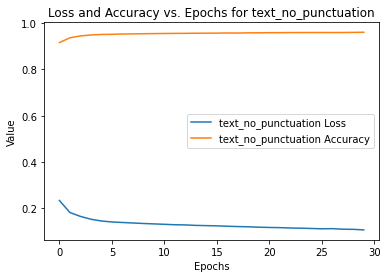

learning rate: 0.0001, total number of epochs: 30
Epoch [1/30], Loss: 0.23205988289395144, Accuracy: 0.9229872595897751
Epoch [2/30], Loss: 0.1863033141932638, Accuracy: 0.9381529225235162
Epoch [3/30], Loss: 0.1629879253179811, Accuracy: 0.9464251023055568
Epoch [4/30], Loss: 0.14948040487546363, Accuracy: 0.9505298581822511
Epoch [5/30], Loss: 0.1433141267366967, Accuracy: 0.9522218949558504
Epoch [6/30], Loss: 0.13954697923090784, Accuracy: 0.953688326826303
Epoch [7/30], Loss: 0.1373812291354535, Accuracy: 0.9542335386755739
Epoch [8/30], Loss: 0.13498752040628043, Accuracy: 0.9546784816790018
Epoch [9/30], Loss: 0.13284282193366534, Accuracy: 0.9553051619655201
Epoch [10/30], Loss: 0.1316170383369197, Accuracy: 0.9551860927110816
Epoch [11/30], Loss: 0.1293493087959062, Accuracy: 0.9558002393918694
Epoch [12/30], Loss: 0.1281104388570628, Accuracy: 0.9560947791265331
Epoch [13/30], Loss: 0.12600026838469608, Accuracy: 0.9567277262159164
Epoch [14/30], Loss: 0.12486996380736161, Ac

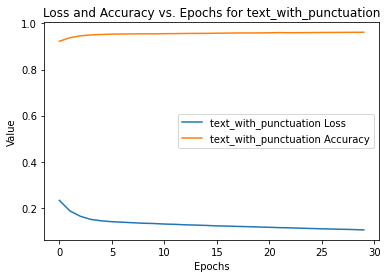

learning rate: 0.0001, total number of epochs: 30
Epoch [1/30], Loss: 0.23058609088565174, Accuracy: 0.923570072256237
Epoch [2/30], Loss: 0.17351961522805148, Accuracy: 0.9436238414248203
Epoch [3/30], Loss: 0.1554864750564417, Accuracy: 0.9496274385696649
Epoch [4/30], Loss: 0.14618473019867834, Accuracy: 0.9530365793283241
Epoch [5/30], Loss: 0.14060256308166533, Accuracy: 0.9547724837219795
Epoch [6/30], Loss: 0.1368499292379833, Accuracy: 0.9557751721804087
Epoch [7/30], Loss: 0.13364218468482716, Accuracy: 0.9567903942445682
Epoch [8/30], Loss: 0.13164890156036763, Accuracy: 0.9566525245815343
Epoch [9/30], Loss: 0.13083374471329542, Accuracy: 0.9569407975133326
Epoch [10/30], Loss: 0.12906631089733714, Accuracy: 0.9575612109969857
Epoch [11/30], Loss: 0.12775637133208345, Accuracy: 0.9584134961866505
Epoch [12/30], Loss: 0.12610632171992467, Accuracy: 0.9580688220290654
Epoch [13/30], Loss: 0.12415952301798433, Accuracy: 0.9587268363299095
Epoch [14/30], Loss: 0.1235711627122858

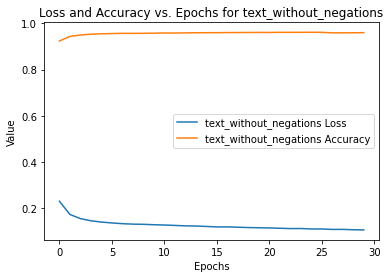

learning rate: 0.0001, total number of epochs: 30
Epoch [1/30], Loss: 0.23271853229845066, Accuracy: 0.9232817993244387
Epoch [2/30], Loss: 0.17762345138802835, Accuracy: 0.9404716395836337
Epoch [3/30], Loss: 0.16290630025002054, Accuracy: 0.9450526724780819
Epoch [4/30], Loss: 0.1510673377359357, Accuracy: 0.9495773041467435
Epoch [5/30], Loss: 0.14137353898386268, Accuracy: 0.9524788338733229
Epoch [6/30], Loss: 0.13556195037604601, Accuracy: 0.9542147382669783
Epoch [7/30], Loss: 0.13180311761043975, Accuracy: 0.9556185021087792
Epoch [8/30], Loss: 0.12942985724735398, Accuracy: 0.9559381090549035
Epoch [9/30], Loss: 0.1269638716595867, Accuracy: 0.9567715938359727
Epoch [10/30], Loss: 0.1259940833949145, Accuracy: 0.9569971987391193
Epoch [11/30], Loss: 0.12411269661937314, Accuracy: 0.9575674777998509
Epoch [12/30], Loss: 0.12199181844673142, Accuracy: 0.958225492100695
Epoch [13/30], Loss: 0.12130118702982165, Accuracy: 0.9586140338783363
Epoch [14/30], Loss: 0.11940923169934155

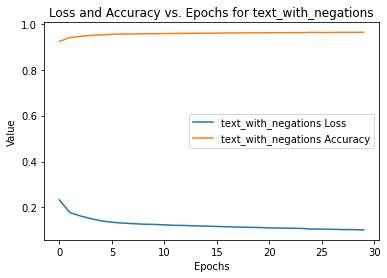

learning rate: 0.0001, total number of epochs: 30
Epoch [1/30], Loss: 0.22787847136556574, Accuracy: 0.9191707766448791
Epoch [2/30], Loss: 0.1712947337226688, Accuracy: 0.9399765621572842
Epoch [3/30], Loss: 0.15356122835990127, Accuracy: 0.9478790005702791
Epoch [4/30], Loss: 0.14153926826045418, Accuracy: 0.9519148216154565
Epoch [5/30], Loss: 0.13529321417498028, Accuracy: 0.9538073960807415
Epoch [6/30], Loss: 0.1316048357983972, Accuracy: 0.9547348829047885
Epoch [7/30], Loss: 0.12874725947814097, Accuracy: 0.95599451028069
Epoch [8/30], Loss: 0.1262719250249432, Accuracy: 0.9559255754491731
Epoch [9/30], Loss: 0.124043070590977, Accuracy: 0.9573168056852436
Epoch [10/30], Loss: 0.12225252868823039, Accuracy: 0.9577993495058625
Epoch [11/30], Loss: 0.11941712036127597, Accuracy: 0.958670435104123
Epoch [12/30], Loss: 0.11839406423842916, Accuracy: 0.9590777772903598
Epoch [13/30], Loss: 0.11742795904425095, Accuracy: 0.9593723170250233
Epoch [14/30], Loss: 0.11463364466329032, Ac

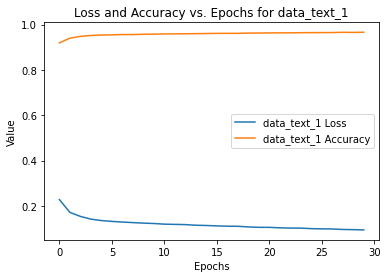

learning rate: 0.0001, total number of epochs: 30
Epoch [1/30], Loss: 0.23113093485588715, Accuracy: 0.9222916444717398
Epoch [2/30], Loss: 0.1807950422753147, Accuracy: 0.9399828289601494
Epoch [3/30], Loss: 0.16232917492459276, Accuracy: 0.9465504383628605
Epoch [4/30], Loss: 0.15012129261244173, Accuracy: 0.9500347807559018
Epoch [5/30], Loss: 0.14372952184528132, Accuracy: 0.95237856502748
Epoch [6/30], Loss: 0.14027223433976208, Accuracy: 0.9533561862744484
Epoch [7/30], Loss: 0.1368006940074337, Accuracy: 0.9539452657437755
Epoch [8/30], Loss: 0.1347159864348184, Accuracy: 0.9546220804532152
Epoch [9/30], Loss: 0.13269027115045318, Accuracy: 0.9548790193706876
Epoch [10/30], Loss: 0.13159524187288443, Accuracy: 0.955267561148329
Epoch [11/30], Loss: 0.12929304897629332, Accuracy: 0.9557438381660828
Epoch [12/30], Loss: 0.12845940780073248, Accuracy: 0.9558754410262517
Epoch [13/30], Loss: 0.1260414058591499, Accuracy: 0.957160135613614
Epoch [14/30], Loss: 0.1251399673954359, Acc

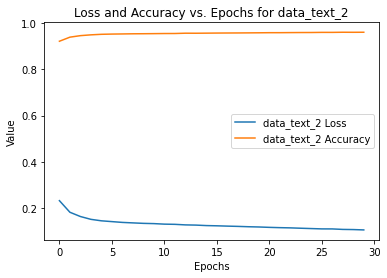

learning rate: 0.0001, total number of epochs: 30
Epoch [1/30], Loss: 0.24423349103347777, Accuracy: 0.9082164052365405
Epoch [2/30], Loss: 0.19236626038959137, Accuracy: 0.9334904211918206
Epoch [3/30], Loss: 0.17443109357776723, Accuracy: 0.9409604502071178
Epoch [4/30], Loss: 0.1603150260740097, Accuracy: 0.9457858884133081
Epoch [5/30], Loss: 0.15147058469479904, Accuracy: 0.9491323611433156
Epoch [6/30], Loss: 0.14546938129683498, Accuracy: 0.9506238602252289
Epoch [7/30], Loss: 0.1419179771527199, Accuracy: 0.9518960212068609
Epoch [8/30], Loss: 0.14050737799722834, Accuracy: 0.9522594957730415
Epoch [9/30], Loss: 0.13813563345192503, Accuracy: 0.95306791334265
Epoch [10/30], Loss: 0.1361104355946117, Accuracy: 0.9534564551202913
Epoch [11/30], Loss: 0.13571390524324556, Accuracy: 0.9538011292778763
Epoch [12/30], Loss: 0.13380507323708302, Accuracy: 0.9545844796360241
Epoch [13/30], Loss: 0.13211160246521234, Accuracy: 0.9548351517506314
Epoch [14/30], Loss: 0.1313543642603879, 

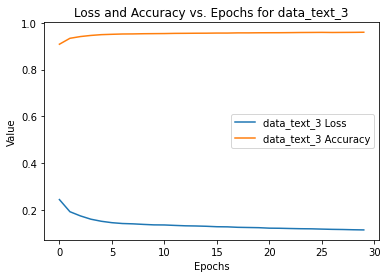

learning rate: 0.0001, total number of epochs: 30
Epoch [1/30], Loss: 0.23334883980271806, Accuracy: 0.9227616546866285
Epoch [2/30], Loss: 0.18483524745753038, Accuracy: 0.9387106679785174
Epoch [3/30], Loss: 0.16688626069177995, Accuracy: 0.9448396011806657
Epoch [4/30], Loss: 0.1538951531263494, Accuracy: 0.94894435705736
Epoch [5/30], Loss: 0.14786228371802407, Accuracy: 0.9510876036372524
Epoch [6/30], Loss: 0.14340851391989554, Accuracy: 0.9519461556297824
Epoch [7/30], Loss: 0.14015472377873245, Accuracy: 0.9527169723821998
Epoch [8/30], Loss: 0.1382135706747825, Accuracy: 0.9534000538945047
Epoch [9/30], Loss: 0.13606422501194704, Accuracy: 0.9537635284606852
Epoch [10/30], Loss: 0.13530549322989094, Accuracy: 0.9541144694211354
Epoch [11/30], Loss: 0.13368526148309995, Accuracy: 0.9544654103815856
Epoch [12/30], Loss: 0.13210673413784207, Accuracy: 0.954653414467541
Epoch [13/30], Loss: 0.13051921754397194, Accuracy: 0.955236227134003
Epoch [14/30], Loss: 0.12915819341588924, 

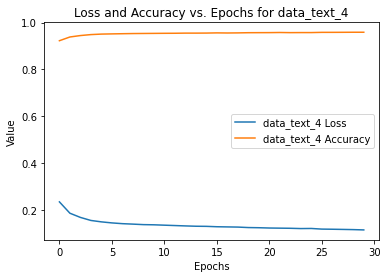

In [140]:
# for all the columns load them into X_train
# make the tensors, train the cnn and thenn take the outcome and add it to a df
columnName = ['text_no_punctuation', 'text_with_punctuation', 'text_without_negations', 'text_with_negations', 
              'data_text_1', 'data_text_2', 'data_text_3', 'data_text_4']

results = []
all_train_loss = []
all_train_accuracy = []
for name in columnName:
    X_train, y_train, X_test, y_test = datasetDefinition(name)
    X_train_T, y_train_T, X_test_T, y_test_T = makeToTensors(X_train, y_train, X_test, y_test)
    
    # Get the test accuracy using the best model
    accuracy, model, train_loss, train_accuracy = trainCNN(X_train_T, y_train_T, X_test_T, y_test_T, epochs=30, learning_rate=0.0001)
    
    all_train_loss.append(train_loss)
    all_train_accuracy.append(train_accuracy)

    plt.plot(train_loss, label=f'{name} Loss')
    plt.plot(train_accuracy, label=f'{name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.title(f'Loss and Accuracy vs. Epochs for {name}')
    plt.legend()
    plt.savefig(f'Loss_Accuracy_Epochs_{name}.png')
    plt.show()

    results.append({'Column': name, 'Test_Accuracy': accuracy})

results_df = pd.DataFrame(results)
results_df.to_csv('hyperparameter_tuning_results.csv', index=False)

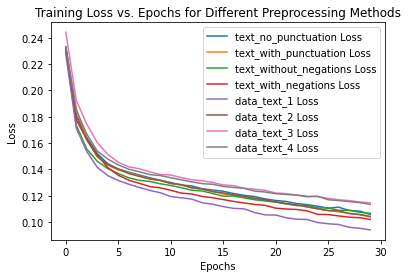

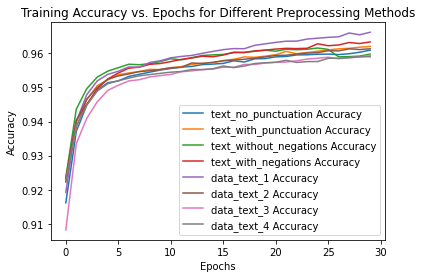

In [141]:

for i, name in enumerate(columnName):
    plt.plot(all_train_loss[i], label=f'{name} Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs for Different Preprocessing Methods')
plt.legend()
plt.savefig(f'Training_Loss_Epochs.png')
plt.show()

for i, name in enumerate(columnName):
    plt.plot(all_train_accuracy[i], label=f'{name} Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Epochs for Different Preprocessing Methods')
plt.legend()
plt.savefig(f'Training_Accuracy.png')
plt.show()

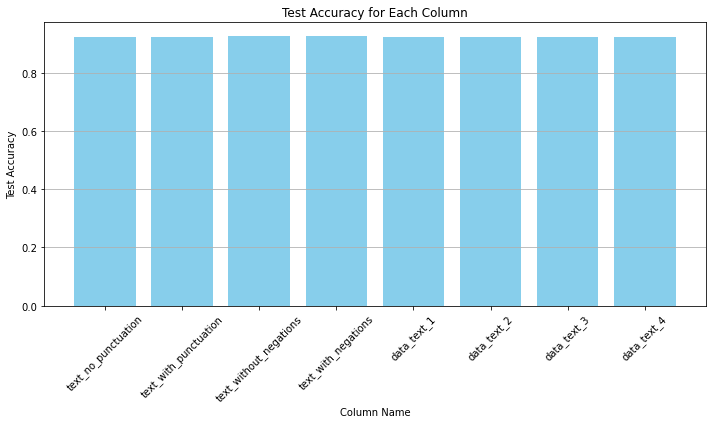

In [142]:
column_names = results_df['Column']
test_accuracy = results_df['Test_Accuracy']

plt.figure(figsize=(10, 6))
plt.bar(column_names, test_accuracy, color='skyblue')
plt.title('Test Accuracy for Each Column')
plt.xlabel('Column Name')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('Test_Accuracy.png')
plt.show()

In [143]:
df_loss = pd.DataFrame(all_train_loss, columns=['Train_Loss'])
df_accuracy = pd.DataFrame(all_train_accuracy, columns=['Train_Accuracy'])

# Concatenate DataFrames
df_combined = pd.concat([df_loss, df_accuracy], axis=1)

# Save as CSV
df_combined.to_csv('train_metrics.csv', index=False)

ValueError: 1 columns passed, passed data had 30 columns

In [ ]:

columnName = ['text_no_punctuation', 'text_with_punctuation', 'text_without_negations', 
              'text_with_negations', 'data_text_1', 'data_text_2', 'data_text_3', 'data_text_4']

metrics_dict = {'accuracy': [], 'f1-score': [], 'recall': []}
linear_pipeline = make_pipeline(
    TfidfVectorizer(max_features=1000),
    LogisticRegression(solver='sag', max_iter=1000)
)
for name in columnName:
    X_train, y_train, X_test, y_test = datasetDefinition(name)
    linear_pipeline.fit(X_train, y_train)
    y_pred = linear_pipeline.predict(X_test)
    print(name, classification_report(y_test, y_pred))
    metrics_dict['accuracy'].append(classification_report['accuracy_score'])
    metrics_dict['f1-score'].append(classification_report['macro avg']['f1-score'])
    metrics_dict['recall'].append(classification_report['macro avg']['recall'])
    

for metric in metrics_dict.keys():
    plt.figure(figsize=(10, 6))
    plt.bar(columnName, metrics_dict[metric], color='skyblue')
    plt.title(f'{metric.capitalize()} for each Column')
    plt.xlabel('Column Name')
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

KeyError: 'text_no_punctuation'

In [145]:
df_loss = pd.DataFrame(all_train_loss, columns=['Train_Loss'])
df_accuracy = pd.DataFrame(all_train_accuracy, columns=['Train_Accuracy'])


[[0.23316133653136095, 0.18110790047117323, 0.1642788691435557, 0.1520007972978777, 0.1443416352926655, 0.14024240352690007, 0.13791848283092698, 0.13573324089393105, 0.13363200774078085, 0.13181209746557265, 0.13002705235425233, 0.1281422173167677, 0.12740093802510477, 0.12533594518199898, 0.1243270925446625, 0.12335105710888887, 0.12164145668016534, 0.12029664071565062, 0.11932757076477539, 0.11756258175740238, 0.11637886211879377, 0.11562260559239408, 0.11404613556751647, 0.11320405721954437, 0.11200549923612572, 0.11056929451470142, 0.11125259631084337, 0.10878155911028543, 0.10832809336632301, 0.1057756416658247], [0.23205988289395144, 0.1863033141932638, 0.1629879253179811, 0.14948040487546363, 0.1433141267366967, 0.13954697923090784, 0.1373812291354535, 0.13498752040628043, 0.13284282193366534, 0.1316170383369197, 0.1293493087959062, 0.1281104388570628, 0.12600026838469608, 0.12486996380736161, 0.12334122623811096, 0.12127426122630278, 0.1204763736426739, 0.1190508189511203, 0.1

In [148]:
import csv
file_name = 'all_train_loss.csv'

# Write the data to the CSV file
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    for loss_list in all_train_loss:
        writer.writerow(loss_list)

In [149]:
file_name = 'all_train_accuracy.csv'

# Write the data to the CSV file
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    for accuracy_list in all_train_accuracy:
        writer.writerow(accuracy_list)